In [50]:
import xarray as xr
import os
import yaml
from datetime import datetime
import glob
import logging
import dask
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt

In [52]:

def remove_depth(ds):
    # Drop additional coordinates except latitude, longitude, and time
    drop_coords = [coord for coord in ds.coords if coord not in ['latitude', 'longitude', 'time']]
    ds = ds.drop_vars(drop_coords)

    if 'depth' in ds.coords:
        ds = ds.isel(depth=0)   

    for var in ds.data_vars:    
        if 'depth' in ds[var].dims:
            ds = ds.isel(depth=0)
    return ds

data_dir = 'data/cmems_mod_glo_bgc_my_0.25deg_P1D-m'
files = os.listdir(data_dir)
ds_bgc = xr.open_mfdataset(os.path.join(data_dir, '*.nc'), engine='netcdf4')
ds_bgc = ds_bgc.compute()


data_dir = 'data/cmems_mod_glo_phy_my_0.083deg_P1D-m'
files = os.listdir(data_dir)
ds_phy = xr.open_mfdataset(os.path.join(data_dir, '*.nc'), engine='netcdf4')
ds_phy = ds_phy.compute()


ds_phy_myint = xr.open_dataset('data/cmems_mod_glo_phy_myint_0.083deg_P1D-m/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_92.00W-86.00W_24.00N-31.00N_0.49m_2021-08-01-2021-10-31.nc')
ds_phy_myint = ds_phy_myint.compute()


ds_phy_merge = xr.merge([ds_phy, ds_phy_myint])


ds_phy_merge = remove_depth(ds_phy_merge)
ds_bgc = remove_depth(ds_bgc)

ds_bgc_interp = ds_bgc.interp_like(ds_phy_merge, method="nearest")
merged_ds = xr.merge([ds_phy_merge, ds_bgc_interp])


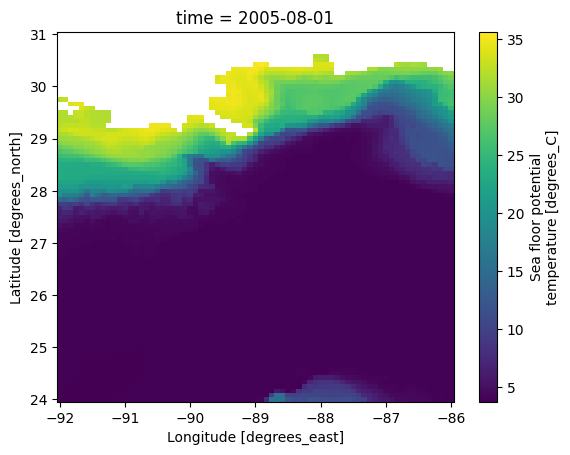

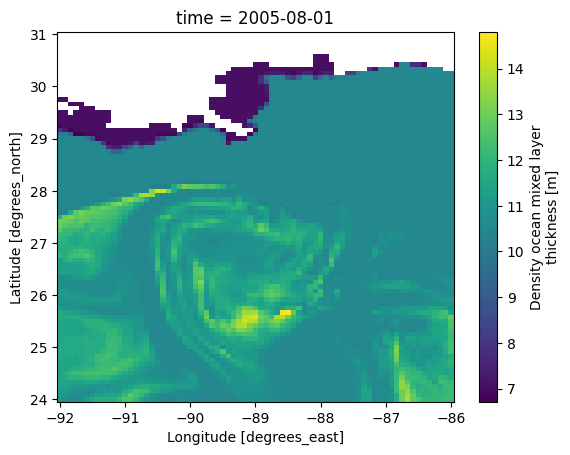

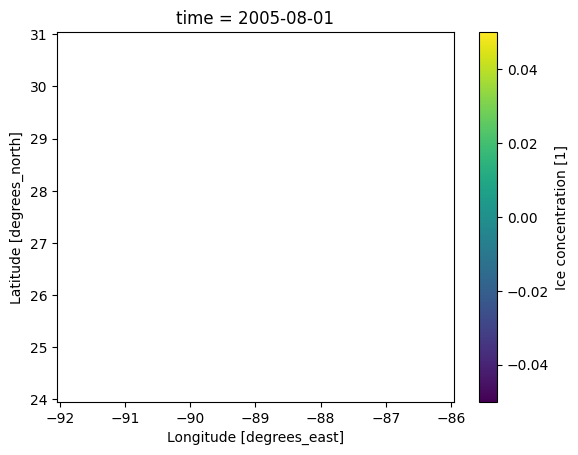

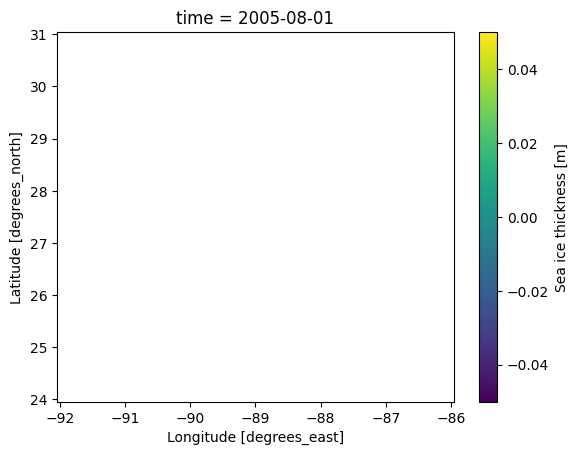

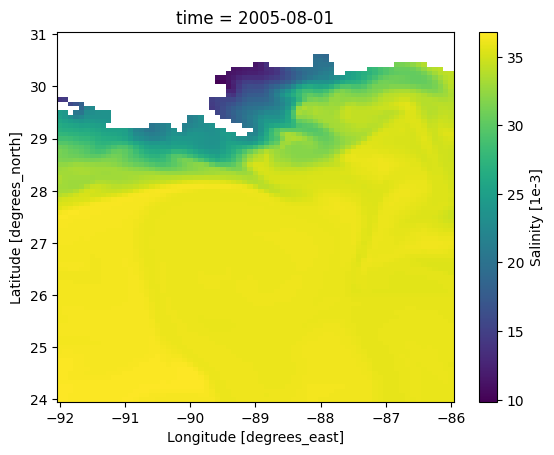

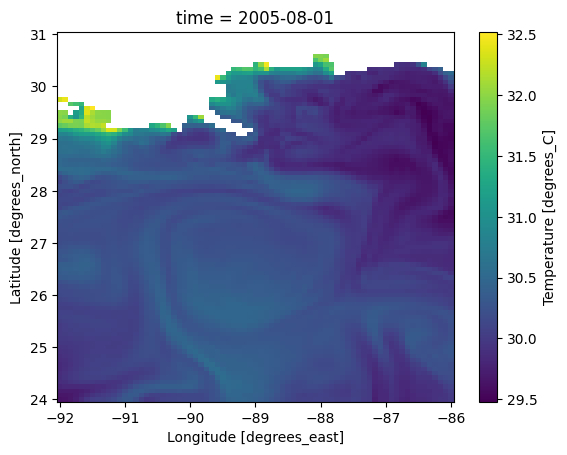

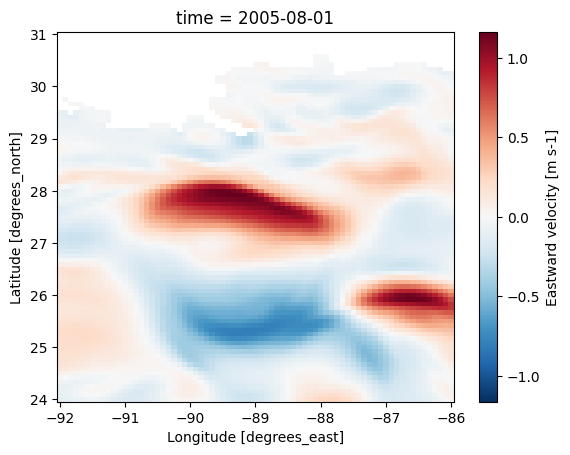

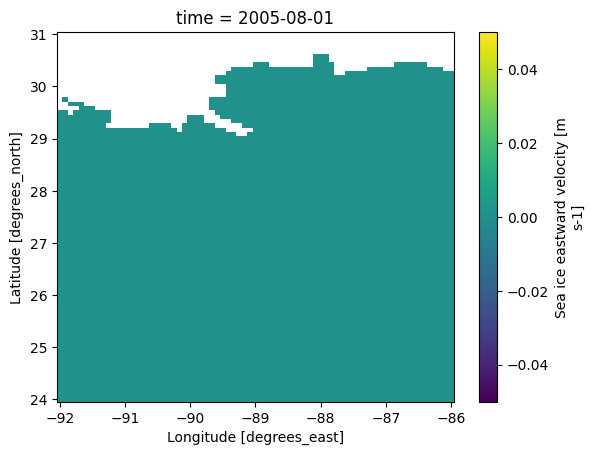

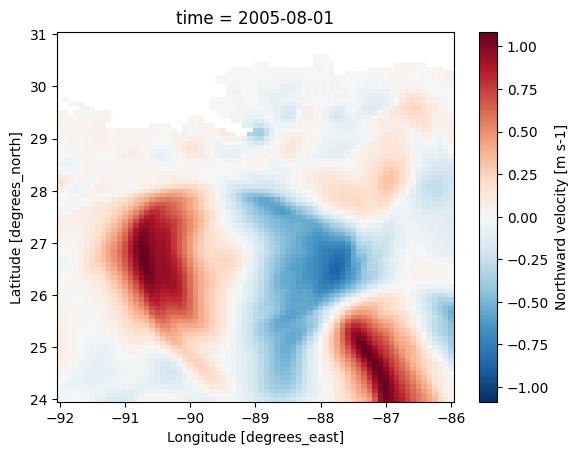

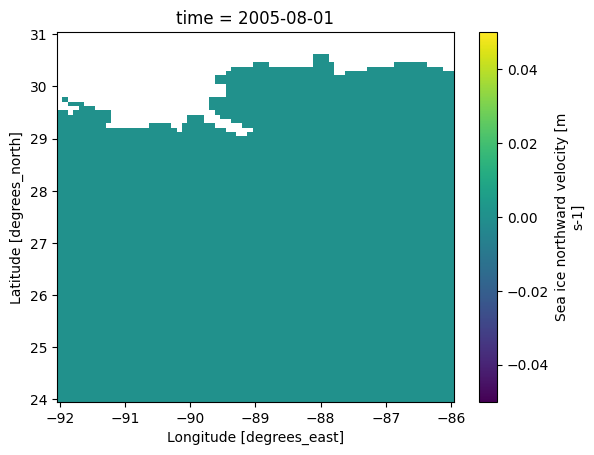

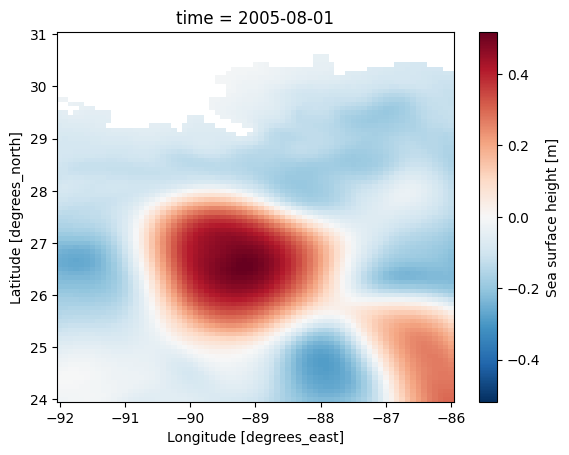

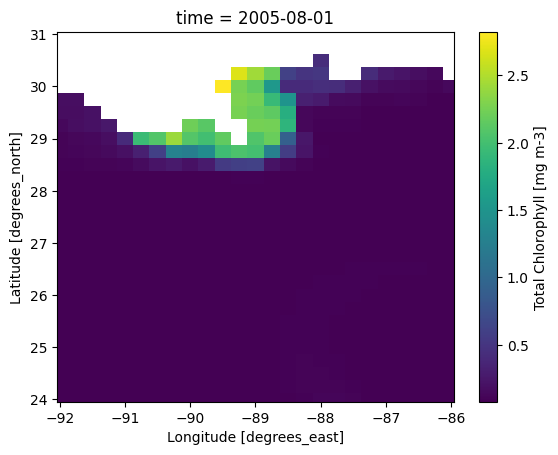

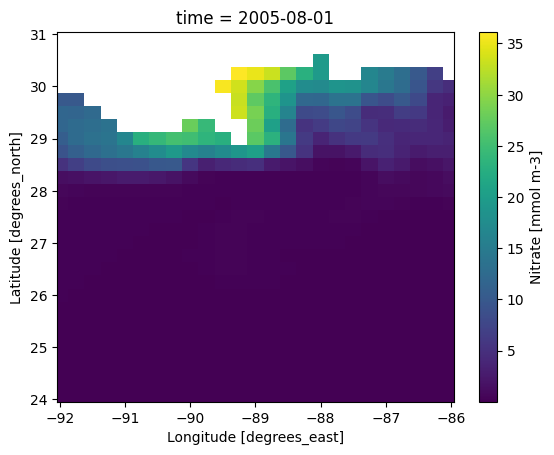

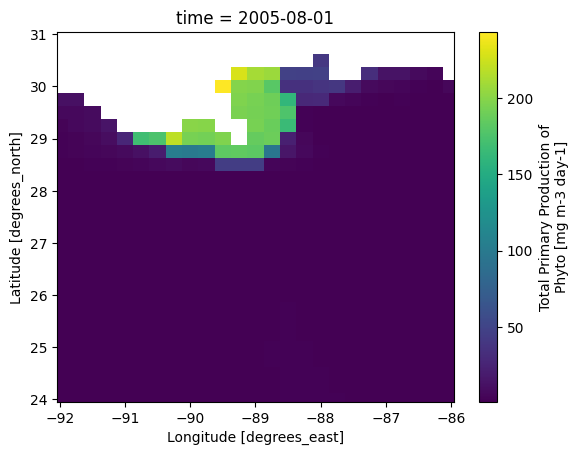

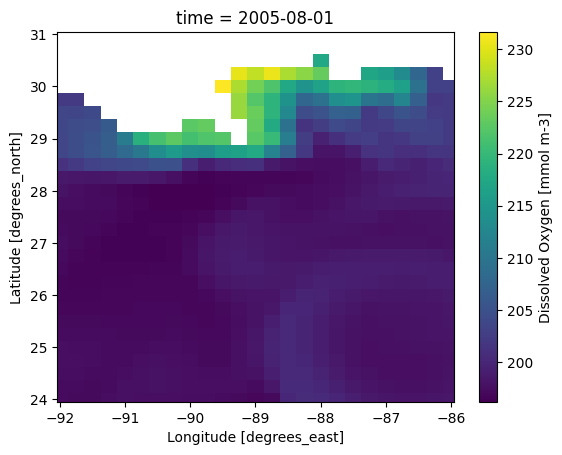

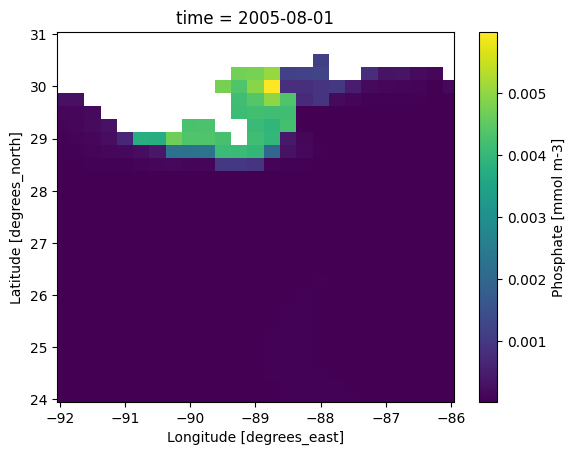

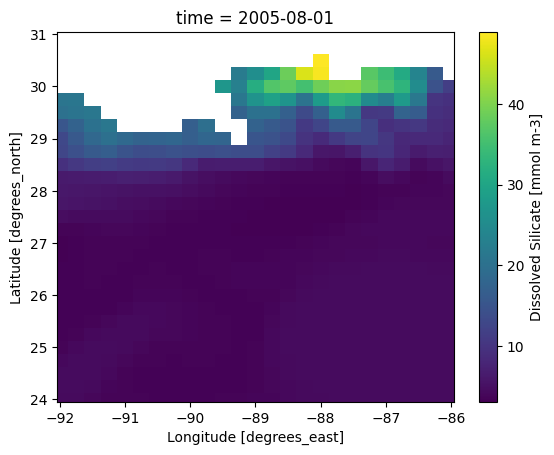

In [53]:
data_vars = list(merged_ds.data_vars.keys())
for var in data_vars:
    merged_ds.isel(time=0)[var].plot()
    plt.show()

In [56]:
merged_ds

<xarray.Dataset> Size: 384MB
Dimensions:    (latitude: 85, longitude: 73, time: 552)
Coordinates:
  * latitude   (latitude) float32 340B 24.0 24.08 24.17 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 292B -92.0 -91.92 -91.83 ... -86.08 -86.0
  * time       (time) datetime64[ns] 4kB 2005-08-01 2005-08-02 ... 2021-10-31
Data variables: (12/17)
    bottomT    (time, latitude, longitude) float64 27MB 3.894 3.894 ... nan nan
    mlotst     (time, latitude, longitude) float64 27MB 10.99 10.68 ... nan nan
    siconc     (time, latitude, longitude) float64 27MB nan nan nan ... nan nan
    sithick    (time, latitude, longitude) float64 27MB nan nan nan ... nan nan
    so         (time, latitude, longitude) float64 27MB 36.72 36.7 ... nan nan
    thetao     (time, latitude, longitude) float64 27MB 29.63 29.64 ... nan nan
    ...         ...
    chl        (time, latitude, longitude) float32 14MB 0.08365 0.08365 ... nan
    no3        (time, latitude, longitude) float32 14MB 0.00923 0.00923 ... nan
    nppv       (time, latitude, longitude) float32 14MB 1.267 1.267 ... nan nan
    o2         (time, latitude, longitude) float32 14MB 197.2 197.2 ... nan nan
    po4        (time, latitude, longitude) float32 14MB 3.827e-05 ... nan
    si         (time, latitude, longitude) float32 14MB 4.216 4.216 ... nan nan
Attributes:
    source:                    MERCATOR GLORYS12V1
    comment:                   CMEMS product
    title:                     daily mean fields from Global Ocean Physics An...
    references:                http://www.mercator-ocean.fr
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    institution:               MERCATOR OCEAN
    copernicusmarine_version:  2.0.0

In [55]:
# save merged_ds to netcdf
merged_ds.to_netcdf('data/merged_ds.nc')

In [59]:
ds_phy.info()

xarray.Dataset {
dimensions:
	time = 460 ;
	latitude = 85 ;
	longitude = 73 ;
	depth = 1 ;

variables:
	float64 bottomT(time, latitude, longitude) ;
		bottomT:cell_methods = area: mean ;
		bottomT:long_name = Sea floor potential temperature ;
		bottomT:standard_name = sea_water_potential_temperature_at_sea_floor ;
		bottomT:unit_long = Degrees Celsius ;
		bottomT:units = degrees_C ;
		bottomT:valid_max = 21299 ;
		bottomT:valid_min = -32756 ;
	float64 mlotst(time, latitude, longitude) ;
		mlotst:cell_methods = area: mean ;
		mlotst:long_name = Density ocean mixed layer thickness ;
		mlotst:standard_name = ocean_mixed_layer_thickness_defined_by_sigma_theta ;
		mlotst:unit_long = Meters ;
		mlotst:units = m ;
		mlotst:valid_max = 4525 ;
		mlotst:valid_min = 1 ;
	float64 siconc(time, latitude, longitude) ;
		siconc:cell_methods = area: mean where sea_ice ;
		siconc:long_name = Ice concentration ;
		siconc:standard_name = sea_ice_area_fraction ;
		siconc:unit_long = Fraction ;
		siconc:uni

In [58]:
ds_bgc.info()

xarray.Dataset {
dimensions:
	time = 552 ;
	latitude = 29 ;
	longitude = 25 ;

variables:
	float32 chl(time, latitude, longitude) ;
		chl:long_name = Total Chlorophyll ;
		chl:standard_name = mass_concentration_of_chlorophyll_a_in_sea_water ;
		chl:unit_long = milligram of Chlorophyll per cubic meter ;
		chl:units = mg m-3 ;
		chl:valid_max = 15.035151481628418 ;
		chl:valid_min = 0.002630323637276888 ;
	float32 no3(time, latitude, longitude) ;
		no3:long_name = Nitrate ;
		no3:standard_name = mole_concentration_of_nitrate_in_sea_water ;
		no3:unit_long = millimoles of Nitrate per cubic meter ;
		no3:units = mmol m-3 ;
		no3:valid_max = 78.23329162597656 ;
		no3:valid_min = 0.0 ;
	float32 nppv(time, latitude, longitude) ;
		nppv:long_name = Total Primary Production of Phyto ;
		nppv:standard_name = net_primary_production_of_biomass_expressed_as_carbon_per_unit_volume_in_sea_water ;
		nppv:unit_long = milligrams of Carbon per cubic meter per day ;
		nppv:units = mg m-3 day-1 ;
		nppv:va